In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [3]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('default')
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [5]:

from tensorflow import keras
import keras_tuner as kt
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [6]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [7]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

In [8]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [8]:
# load dataset
df_raw = pd.read_sas(here() / config.data / 'external' / 'cibmtr' / 'cibmtr.sas7bdat', encoding='latin1')

In [9]:
df_raw

coll_yr  twodaycoll  wbc0   plt0  hgb0  skeletal0  maxmtc0  wbc5pre  \
0       2008.0         0.0   3.8  159.0  15.5        0.0      0.0     13.0   
1       2015.0         0.0   5.5  218.0  13.2        0.0      0.0     31.2   
2       2007.0         0.0   6.1  175.0  15.0        0.0      0.0     31.5   
3       2011.0         0.0   8.0  280.0  15.4        1.0      0.0     68.4   
4       2008.0         0.0   8.1  351.0  13.2        0.0      0.0     34.0   
...        ...         ...   ...    ...   ...        ...      ...      ...   
22343   2013.0         1.0   5.2  361.0   8.7        0.0      0.0     25.5   
22344   2015.0         1.0   5.7  296.0  15.6        0.0      0.0     35.0   
22345   2007.0         1.0   6.0  335.0  14.0        0.0      0.0     18.3   
22346   2008.0         1.0  10.6  398.0   9.6        0.0      0.0     69.9   
22347   2013.0         1.0  10.0  434.0  15.0        0.0      0.0     60.9   

       plt5pre  hgb5pre  ...  drace  coll_age_gp  hosp5n  hypo_cad5  \
0        136.0     14.4  ...    7.0          4.0     0.0        0.0   
1        232.0     12.2  ...    1.0          4.0     0.0        1.0   
2        181.0     14.9  ...    7.0          4.0     0.0        0.0   
3        230.0     15.9  ...    1.0          4.0     0.0        1.0   
4        278.0     11.7  ...    7.0          4.0     0.0        0.0   
...        ...      ...  ...    ...          ...     ...        ...   
22343    350.0      9.3  ...    4.0          2.0     0.0        0.0   
22344    323.0     15.0  ...    1.0          3.0     0.0        0.0   
22345    327.0     12.9  ...    1.0          1.0     0.0        1.0   
22346    409.0     10.0  ...    1.0          3.0     0.0        0.0   
22347    413.0     14.6  ...    1.0          1.0     0.0        0.0   

       hypo_cad5_6  clined5  clined5_6     pseudoid   pseudoctr  \
0              0.0      0.0        0.0   93409976.0  10366760.0   
1              1.0      0.0        0.0   93370093.0  10366776.0   
2              0.0      0.0        0.0   93323774.0  10366760.0   
3              1.0      0.0        0.0   93344918.0  10366785.0   
4              0.0      0.0        0.0   93355053.0  10366760.0   
...            ...      ...        ...          ...         ...   
22343          0.0      0.0        0.0   27583677.0  10366763.0   
22344          0.0      0.0        0.0   34469796.0  10366763.0   
22345          1.0      0.0        0.0   26517063.0  10366965.0   
22346          0.0      0.0        1.0  122124260.0  10366817.0   
22347          0.0      0.0        0.0   49480485.0  10366763.0   

       RqstgtcollectedDay1  
0                     -9.0  
1                      0.0  
2                     -9.0  
3                     -9.0  
4                     -9.0  
...                    ...  
22343                 -9.0  
22344                 -9.0  
22345                 -9.0  
22346                 -9.0  
22347                 -9.0  

[22348 rows x 77 columns]

In [10]:

# check whether pseudoid is unique
if df_raw['pseudoid'].is_unique:
    print("pseudoid is unique")
else:
    print("pseudoid is not unique, dropping duplicates")
    # print the number of duplicates
    print(f"Number of duplicates: {df_raw['pseudoid'].duplicated().sum()}")
    df_raw = df_raw.drop_duplicates(subset='pseudoid')

pseudoid is not unique, dropping duplicates
Number of duplicates: 447


In [11]:
cols_to_keep = [ 'pseudoid', # unique identifier
                'twodaycoll', # collection day
                'dsex', # donor sex
                'coll_age_gp', # collection age group
                'd_wt', # donor weight
                'd_bmi_grp', # donor BMI group
                'wbc0', # white blood cell count at baseline
                'plt0', # platelet count at baseline
                'hgb0', # hemoglobin at baseline
                'absneut0', # absolute neutrophil count at baseline
                'absmnc0', # absolute monocyte count at baseline
                'wbc5pre', # white blood cell count at 5 day
                'absneut5pre', # absolute neutrophil count at 5 day
                'absmnc5pre', # absolute monocyte count at 5 day
                'abscd34_5pre', # absolute CD34 count at 5 day
                'plt5pre',  # platelet count at 5 day
                'hgb5pre', # hemoglobin at 5 day
                # 'wbc6pre', # white blood cell count at 6 day
                # 'absneut6pre', # absolute neutrophil count at 6 day
                # 'absmnc6pre', # absolute monocyte count at 6 day
                # 'abscd34_6pre', # absolute CD34 count at 6 day
                ]

In [12]:
# keep only the columns of interest
df = df_raw[cols_to_keep].copy()
df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0   3.8   
1       93370093.0         0.0   2.0          4.0   79.00        3.0   5.5   
2       93323774.0         0.0   1.0          4.0  124.00        4.0   6.1   
3       93344918.0         0.0   1.0          4.0   84.00        3.0   8.0   
4       93355053.0         0.0   2.0          4.0   94.00        4.0   8.1   
...            ...         ...   ...          ...     ...        ...   ...   
22343   27583677.0         1.0   2.0          2.0   63.00        3.0   5.2   
22344   34469796.0         1.0   1.0          3.0   70.00        2.0   5.7   
22345   26517063.0         1.0   2.0          1.0   77.00        3.0   6.0   
22346  122124260.0         1.0   2.0          3.0   96.81        4.0  10.6   
22347   49480485.0         1.0   1.0          1.0  119.00        4.0  10.0   

        plt0  hgb0  absneut0  absmnc0  wbc5pre  absneut5pre  absmnc5pre  \
0      159.0  15.5      2.24     1.56     13.0        10.79        2.21   
1      218.0  13.2      3.00     2.49     31.2        26.36        4.80   
2      175.0  15.0      3.23     2.87     31.5        26.46        5.04   
3      280.0  15.4      5.04     2.96     68.4        60.19        8.21   
4      351.0  13.2      4.94     3.16     34.0        26.18        7.82   
...      ...   ...       ...      ...      ...          ...         ...   
22343  361.0   8.7      2.91     2.29     25.5        20.15        5.36   
22344  296.0  15.6      3.53     2.11     35.0        27.65        7.00   
22345  335.0  14.0      3.40     2.60     18.3        12.81        5.49   
22346  398.0   9.6      7.84     2.76     69.9        58.72       11.18   
22347  434.0  15.0      6.10     3.90     60.9        51.16        9.74   

       abscd34_5pre  plt5pre  hgb5pre  
0             11.70    136.0     14.4  
1             70.20    232.0     12.2  
2             22.05    181.0     14.9  
3             87.55    230.0     15.9  
4             51.00    278.0     11.7  
...             ...      ...      ...  
22343         38.25    350.0      9.3  
22344         59.50    323.0     15.0  
22345         49.41    327.0     12.9  
22346        174.75    409.0     10.0  
22347        127.89    413.0     14.6  

[21901 rows x 17 columns]

In [13]:
# display the rows with any missing values
df[df.isnull().any(axis=1)]

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0  \
87      95468317.0         0.0   2.0          4.0   65.00        2.0   4.2   
127     94426132.0         0.0   2.0          3.0  117.94        4.0   5.9   
128     94434419.0         0.0   2.0          4.0   72.58        3.0   7.1   
136     94637814.0         0.0   1.0          2.0  130.00        4.0   6.1   
187     98375675.0         0.0   1.0          3.0   60.90        2.0   5.3   
...            ...         ...   ...          ...     ...        ...   ...   
22296   75264929.0         1.0   1.0          2.0  123.00        4.0   7.7   
22304   17779274.0         1.0   2.0          1.0  104.54        4.0   7.2   
22327  110044738.0         1.0   2.0          1.0   79.54        3.0   8.4   
22331   71277921.0         1.0   1.0          2.0   90.00        4.0  11.0   
22337  120183621.0         1.0   2.0          4.0  100.00        4.0   7.4   

        plt0  hgb0  absneut0  absmnc0  wbc5pre  absneut5pre  absmnc5pre  \
87     276.0  13.8      1.98      NaN    23.50        19.04        4.47   
127    231.0  12.9      3.12     2.78    33.80        28.39        5.41   
128    315.0  13.3      4.63     2.47    63.80        56.14         NaN   
136    200.0  15.5      4.33     1.83    18.50        12.95        5.55   
187    171.0  13.6      2.76     2.54    31.00        24.80        6.20   
...      ...   ...       ...      ...      ...          ...         ...   
22296  303.0  14.7      5.41     2.29    45.28        39.39        5.89   
22304  320.0  13.1      4.41     2.79    58.70        49.90        8.81   
22327  338.0  12.6      6.28     2.12    48.90        44.99         NaN   
22331  384.0  15.0      6.93     4.07    29.40        24.70        4.70   
22337  376.0  14.0      5.55     1.85    56.80        49.42        7.38   

       abscd34_5pre  plt5pre  hgb5pre  
87            33.37    225.0     11.7  
127             NaN    203.0     12.6  
128          192.68    384.0     12.9  
136             NaN    190.0     14.4  
187             NaN    159.0     12.7  
...             ...      ...      ...  
22296           NaN    314.0     14.7  
22304        123.27      NaN     13.4  
22327         29.34    385.0     13.2  
22331           NaN    335.0     15.1  
22337           NaN    370.0     14.5  

[660 rows x 17 columns]

In [14]:
# display the rows where d_bmi_grp == 99
df[df['d_bmi_grp'] == 99]

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0  \
1567    82024176.0         0.0   2.0          3.0   59.09       99.0   4.8   
7220   106452445.0         0.0   1.0          3.0  114.00       99.0   5.5   
7656   108559250.0         0.0   1.0          1.0   71.67       99.0   5.0   
11264   23717608.0         0.0   1.0          4.0   69.00       99.0   5.9   
11325   23893387.0         0.0   1.0          1.0   95.26       99.0   5.6   
11491   10267066.0         0.0   1.0          4.0  128.37       99.0   9.1   
14820   60495856.0         0.0   2.0          2.0   75.30       99.0   9.6   
16688   48332933.0         0.0   2.0          3.0   67.00       99.0   8.2   
17700   39493302.0         0.0   2.0          1.0   92.99       99.0  11.6   
19781  452658074.0         0.0   2.0          4.0   80.74       99.0   6.0   
21026  114387202.0         1.0   2.0          2.0   87.00       99.0   4.3   

        plt0  hgb0  absneut0  absmnc0  wbc5pre  absneut5pre  absmnc5pre  \
1567   275.0  13.4      3.17     1.63     52.4        45.06        7.34   
7220   234.0  15.1      3.47     2.04     28.6        23.74        4.86   
7656   258.0  15.6      3.01     1.99     46.3        37.50        8.80   
11264  207.0  13.4      3.95     2.01     52.2        45.94        6.26   
11325  231.0  16.5      3.81     1.79     35.7        20.53       15.17   
11491  239.0  15.0      6.10     3.00     46.5        39.99        6.51   
14820  279.0  13.8      6.68     2.89     48.1        41.85        6.73   
16688  204.0  13.6      5.11     3.05     51.2        45.67        4.86   
17700  430.0  12.6      8.71     2.89     60.6        48.48       12.12   
19781  252.0  13.8      3.65     2.33     46.0        40.43        5.57   
21026  224.0  13.4      2.54     1.76     43.3        37.24        6.06   

       abscd34_5pre  plt5pre  hgb5pre  
1567         110.04    291.0     12.8  
7220          85.80    215.0     15.2  
7656          74.08    256.0     14.9  
11264         73.08    218.0     13.4  
11325        135.66    194.0     15.6  
11491         93.00    272.0     14.9  
14820         86.58    217.0     13.2  
16688         76.80    179.0     13.4  
17700        145.44    419.0     12.1  
19781         23.00    184.0     14.3  
21026        524.80    235.0     14.3

#### Defining the Good and poor Mobilizers in full dataset

In [15]:
# add Count column, if abscd34_5pre is > 40 million, then Count is 1, else 0
df['Count'] = np.where(df['abscd34_5pre'] > 40, 1, 0) # 1 for good and 0 for poor mobilizer
# check the distribution of Count
print(df['Count'].value_counts())


Count
1    18576
0     3325
Name: count, dtype: int64


##### Removing the data with "Twodaycoll" as 1
We're removing the data of the donors who underwent collection over two days and keep only those who underwent collection on a single day. This is done to ensure that the mobilization data is consistent and comparable across all donors without any discrepancies or biases that might arise from multi-day collections.

In [16]:
# remove rows with twodaycoll == 1
df = df[df['twodaycoll'] != 1].copy()
df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0   3.8   
1       93370093.0         0.0   2.0          4.0   79.00        3.0   5.5   
2       93323774.0         0.0   1.0          4.0  124.00        4.0   6.1   
3       93344918.0         0.0   1.0          4.0   84.00        3.0   8.0   
4       93355053.0         0.0   2.0          4.0   94.00        4.0   8.1   
...            ...         ...   ...          ...     ...        ...   ...   
20005  440943238.0         0.0   1.0          1.0   97.52        3.0   6.2   
20006  440944836.0         0.0   1.0          1.0   78.93        2.0   4.6   
20007  440949006.0         0.0   2.0          1.0   72.58        3.0   6.1   
20008  440956226.0         0.0   1.0          1.0   71.67        3.0   3.8   
20009  441127927.0         0.0   2.0          1.0   93.44        3.0   8.7   

        plt0  hgb0  absneut0  absmnc0  wbc5pre  absneut5pre  absmnc5pre  \
0      159.0  15.5      2.24     1.56     13.0        10.79        2.21   
1      218.0  13.2      3.00     2.49     31.2        26.36        4.80   
2      175.0  15.0      3.23     2.87     31.5        26.46        5.04   
3      280.0  15.4      5.04     2.96     68.4        60.19        8.21   
4      351.0  13.2      4.94     3.16     34.0        26.18        7.82   
...      ...   ...       ...      ...      ...          ...         ...   
20005  322.0  15.3      3.97     2.23     52.5        44.63        7.88   
20006  173.0  14.7      2.52     2.08     35.9        31.41        4.49   
20007  295.0  13.3      3.54     2.56     38.9        31.51        7.39   
20008  211.0  14.8      1.61     2.19     28.1        22.06        6.04   
20009  363.0  12.6      5.92     2.69     52.6        46.29        6.31   

       abscd34_5pre  plt5pre  hgb5pre  Count  
0             11.70    136.0     14.4      0  
1             70.20    232.0     12.2      1  
2             22.05    181.0     14.9      0  
3             87.55    230.0     15.9      1  
4             51.00    278.0     11.7      1  
...             ...      ...      ...    ...  
20005        126.00    296.0     14.2      1  
20006         61.03    191.0     14.8      1  
20007        237.29    270.0     13.6      1  
20008         70.25    195.0     14.7      1  
20009        120.98    294.0     12.2      1  

[19617 rows x 18 columns]

In [17]:
# check the distribution of Count
print(df['Count'].value_counts())

Count
1    17004
0     2613
Name: count, dtype: int64


### Defining Pre-G-CSF dataframe

In [18]:
pre_cols = ['pseudoid', 'twodaycoll', 'dsex', 'coll_age_gp', 'd_wt', 'd_bmi_grp',
            'wbc0', # white blood cell count at baseline
            'plt0', # platelet count at baseline
            'hgb0', # hemoglobin at baseline
            'absneut0', # absolute neutrophil count at baseline
            'absmnc0', # absolute monocyte count at baseline
            'abscd34_5pre', # absolute CD34 count at 5 day
            'Count'
            ]
# make a new dataframe with columns from baseline including the demographics
pre_df = df[pre_cols].copy()
pre_df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0   3.8   
1       93370093.0         0.0   2.0          4.0   79.00        3.0   5.5   
2       93323774.0         0.0   1.0          4.0  124.00        4.0   6.1   
3       93344918.0         0.0   1.0          4.0   84.00        3.0   8.0   
4       93355053.0         0.0   2.0          4.0   94.00        4.0   8.1   
...            ...         ...   ...          ...     ...        ...   ...   
20005  440943238.0         0.0   1.0          1.0   97.52        3.0   6.2   
20006  440944836.0         0.0   1.0          1.0   78.93        2.0   4.6   
20007  440949006.0         0.0   2.0          1.0   72.58        3.0   6.1   
20008  440956226.0         0.0   1.0          1.0   71.67        3.0   3.8   
20009  441127927.0         0.0   2.0          1.0   93.44        3.0   8.7   

        plt0  hgb0  absneut0  absmnc0  abscd34_5pre  Count  
0      159.0  15.5      2.24     1.56         11.70      0  
1      218.0  13.2      3.00     2.49         70.20      1  
2      175.0  15.0      3.23     2.87         22.05      0  
3      280.0  15.4      5.04     2.96         87.55      1  
4      351.0  13.2      4.94     3.16         51.00      1  
...      ...   ...       ...      ...           ...    ...  
20005  322.0  15.3      3.97     2.23        126.00      1  
20006  173.0  14.7      2.52     2.08         61.03      1  
20007  295.0  13.3      3.54     2.56        237.29      1  
20008  211.0  14.8      1.61     2.19         70.25      1  
20009  363.0  12.6      5.92     2.69        120.98      1  

[19617 rows x 13 columns]

In [19]:
# drop any rows with missing data
pre_df = pre_df.dropna()
pre_df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0   3.8   
1       93370093.0         0.0   2.0          4.0   79.00        3.0   5.5   
2       93323774.0         0.0   1.0          4.0  124.00        4.0   6.1   
3       93344918.0         0.0   1.0          4.0   84.00        3.0   8.0   
4       93355053.0         0.0   2.0          4.0   94.00        4.0   8.1   
...            ...         ...   ...          ...     ...        ...   ...   
20005  440943238.0         0.0   1.0          1.0   97.52        3.0   6.2   
20006  440944836.0         0.0   1.0          1.0   78.93        2.0   4.6   
20007  440949006.0         0.0   2.0          1.0   72.58        3.0   6.1   
20008  440956226.0         0.0   1.0          1.0   71.67        3.0   3.8   
20009  441127927.0         0.0   2.0          1.0   93.44        3.0   8.7   

        plt0  hgb0  absneut0  absmnc0  abscd34_5pre  Count  
0      159.0  15.5      2.24     1.56         11.70      0  
1      218.0  13.2      3.00     2.49         70.20      1  
2      175.0  15.0      3.23     2.87         22.05      0  
3      280.0  15.4      5.04     2.96         87.55      1  
4      351.0  13.2      4.94     3.16         51.00      1  
...      ...   ...       ...      ...           ...    ...  
20005  322.0  15.3      3.97     2.23        126.00      1  
20006  173.0  14.7      2.52     2.08         61.03      1  
20007  295.0  13.3      3.54     2.56        237.29      1  
20008  211.0  14.8      1.61     2.19         70.25      1  
20009  363.0  12.6      5.92     2.69        120.98      1  

[19217 rows x 13 columns]

In [20]:
if pre_df['pseudoid'].is_unique:
    print("pseudoid is unique in pre_df")
else:
    print("pseudoid is not unique in pre_df, dropping duplicates")
    pre_df = pre_df.drop_duplicates(subset='pseudoid')

pseudoid is unique in pre_df


In [21]:
# remove data with bmi == 99
pre_df = pre_df[pre_df['d_bmi_grp'] != 99].copy()

In [22]:
pre_df = pre_df.drop(columns=['twodaycoll'])  # drop twodaycoll  as they are not needed for the model
pre_df

pseudoid  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc0   plt0  hgb0  \
0       93409976.0   1.0          4.0   93.00        4.0   3.8  159.0  15.5   
1       93370093.0   2.0          4.0   79.00        3.0   5.5  218.0  13.2   
2       93323774.0   1.0          4.0  124.00        4.0   6.1  175.0  15.0   
3       93344918.0   1.0          4.0   84.00        3.0   8.0  280.0  15.4   
4       93355053.0   2.0          4.0   94.00        4.0   8.1  351.0  13.2   
...            ...   ...          ...     ...        ...   ...    ...   ...   
20005  440943238.0   1.0          1.0   97.52        3.0   6.2  322.0  15.3   
20006  440944836.0   1.0          1.0   78.93        2.0   4.6  173.0  14.7   
20007  440949006.0   2.0          1.0   72.58        3.0   6.1  295.0  13.3   
20008  440956226.0   1.0          1.0   71.67        3.0   3.8  211.0  14.8   
20009  441127927.0   2.0          1.0   93.44        3.0   8.7  363.0  12.6   

       absneut0  absmnc0  abscd34_5pre  Count  
0          2.24     1.56         11.70      0  
1          3.00     2.49         70.20      1  
2          3.23     2.87         22.05      0  
3          5.04     2.96         87.55      1  
4          4.94     3.16         51.00      1  
...         ...      ...           ...    ...  
20005      3.97     2.23        126.00      1  
20006      2.52     2.08         61.03      1  
20007      3.54     2.56        237.29      1  
20008      1.61     2.19         70.25      1  
20009      5.92     2.69        120.98      1  

[19207 rows x 12 columns]

In [23]:
# add another column labtype to pre_df and set it to 0
pre_df['labtype'] = 0

In [24]:
pre_df.columns

Index(['pseudoid', 'dsex', 'coll_age_gp', 'd_wt', 'd_bmi_grp', 'wbc0', 'plt0',
       'hgb0', 'absneut0', 'absmnc0', 'abscd34_5pre', 'Count', 'labtype'],
      dtype='object')

In [25]:
# rename the columns in pre_df
pre_df = pre_df.rename(columns={'pseudoid': 'ID', 'dsex' : 'Gender', 'coll_age_gp' : 'Age-Group', 'd_wt' : 'Weight', 'wbc0' : 'WBC', 'plt0' :'Platelet', 'hgb0' : 'HGB',
       'absneut0' : 'Neut Abs', 'absmnc0' : 'MNC Abs', 'abscd34_5pre' : 'CD34 Abs', 'd_bmi_grp': 'BMI Group'})
pre_df

ID  Gender  Age-Group  Weight  BMI Group  WBC  Platelet   HGB  \
0       93409976.0     1.0        4.0   93.00        4.0  3.8     159.0  15.5   
1       93370093.0     2.0        4.0   79.00        3.0  5.5     218.0  13.2   
2       93323774.0     1.0        4.0  124.00        4.0  6.1     175.0  15.0   
3       93344918.0     1.0        4.0   84.00        3.0  8.0     280.0  15.4   
4       93355053.0     2.0        4.0   94.00        4.0  8.1     351.0  13.2   
...            ...     ...        ...     ...        ...  ...       ...   ...   
20005  440943238.0     1.0        1.0   97.52        3.0  6.2     322.0  15.3   
20006  440944836.0     1.0        1.0   78.93        2.0  4.6     173.0  14.7   
20007  440949006.0     2.0        1.0   72.58        3.0  6.1     295.0  13.3   
20008  440956226.0     1.0        1.0   71.67        3.0  3.8     211.0  14.8   
20009  441127927.0     2.0        1.0   93.44        3.0  8.7     363.0  12.6   

       Neut Abs  MNC Abs  CD34 Abs  Count  labtype  
0          2.24     1.56     11.70      0        0  
1          3.00     2.49     70.20      1        0  
2          3.23     2.87     22.05      0        0  
3          5.04     2.96     87.55      1        0  
4          4.94     3.16     51.00      1        0  
...         ...      ...       ...    ...      ...  
20005      3.97     2.23    126.00      1        0  
20006      2.52     2.08     61.03      1        0  
20007      3.54     2.56    237.29      1        0  
20008      1.61     2.19     70.25      1        0  
20009      5.92     2.69    120.98      1        0  

[19207 rows x 13 columns]

### Defining Post-G-CSF data

In [26]:
post_cols = ['pseudoid', 'twodaycoll', 'dsex', 'coll_age_gp', 'd_wt', 'd_bmi_grp',
             'wbc5pre', # white blood cell count at 5 day
                'absneut5pre', # absolute neutrophil count at 5 day
                'absmnc5pre', # absolute monocyte count at 5 day
                'abscd34_5pre', # absolute CD34 count at 5 day
                'plt5pre',  # platelet count at 5 day
                'hgb5pre', # hemoglobin at 5 day
                'Count'
                ]

In [27]:
# make a new dataframe with columns from day 5 including the demographics
post_df = df[post_cols].copy()
post_df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc5pre  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0     13.0   
1       93370093.0         0.0   2.0          4.0   79.00        3.0     31.2   
2       93323774.0         0.0   1.0          4.0  124.00        4.0     31.5   
3       93344918.0         0.0   1.0          4.0   84.00        3.0     68.4   
4       93355053.0         0.0   2.0          4.0   94.00        4.0     34.0   
...            ...         ...   ...          ...     ...        ...      ...   
20005  440943238.0         0.0   1.0          1.0   97.52        3.0     52.5   
20006  440944836.0         0.0   1.0          1.0   78.93        2.0     35.9   
20007  440949006.0         0.0   2.0          1.0   72.58        3.0     38.9   
20008  440956226.0         0.0   1.0          1.0   71.67        3.0     28.1   
20009  441127927.0         0.0   2.0          1.0   93.44        3.0     52.6   

       absneut5pre  absmnc5pre  abscd34_5pre  plt5pre  hgb5pre  Count  
0            10.79        2.21         11.70    136.0     14.4      0  
1            26.36        4.80         70.20    232.0     12.2      1  
2            26.46        5.04         22.05    181.0     14.9      0  
3            60.19        8.21         87.55    230.0     15.9      1  
4            26.18        7.82         51.00    278.0     11.7      1  
...            ...         ...           ...      ...      ...    ...  
20005        44.63        7.88        126.00    296.0     14.2      1  
20006        31.41        4.49         61.03    191.0     14.8      1  
20007        31.51        7.39        237.29    270.0     13.6      1  
20008        22.06        6.04         70.25    195.0     14.7      1  
20009        46.29        6.31        120.98    294.0     12.2      1  

[19617 rows x 13 columns]

In [28]:
# remove any rows with missing data
post_df = post_df.dropna()
post_df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc5pre  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0     13.0   
1       93370093.0         0.0   2.0          4.0   79.00        3.0     31.2   
2       93323774.0         0.0   1.0          4.0  124.00        4.0     31.5   
3       93344918.0         0.0   1.0          4.0   84.00        3.0     68.4   
4       93355053.0         0.0   2.0          4.0   94.00        4.0     34.0   
...            ...         ...   ...          ...     ...        ...      ...   
20005  440943238.0         0.0   1.0          1.0   97.52        3.0     52.5   
20006  440944836.0         0.0   1.0          1.0   78.93        2.0     35.9   
20007  440949006.0         0.0   2.0          1.0   72.58        3.0     38.9   
20008  440956226.0         0.0   1.0          1.0   71.67        3.0     28.1   
20009  441127927.0         0.0   2.0          1.0   93.44        3.0     52.6   

       absneut5pre  absmnc5pre  abscd34_5pre  plt5pre  hgb5pre  Count  
0            10.79        2.21         11.70    136.0     14.4      0  
1            26.36        4.80         70.20    232.0     12.2      1  
2            26.46        5.04         22.05    181.0     14.9      0  
3            60.19        8.21         87.55    230.0     15.9      1  
4            26.18        7.82         51.00    278.0     11.7      1  
...            ...         ...           ...      ...      ...    ...  
20005        44.63        7.88        126.00    296.0     14.2      1  
20006        31.41        4.49         61.03    191.0     14.8      1  
20007        31.51        7.39        237.29    270.0     13.6      1  
20008        22.06        6.04         70.25    195.0     14.7      1  
20009        46.29        6.31        120.98    294.0     12.2      1  

[19158 rows x 13 columns]

In [29]:
if post_df['pseudoid'].is_unique:
    print("pseudoid is unique in post_df")
else:
    print("pseudoid is not unique in post_df, dropping duplicates")
    post_df = post_df.drop_duplicates(subset='pseudoid')

pseudoid is unique in post_df


In [30]:
# remove rows with bmi == 99
post_df = post_df[post_df['d_bmi_grp'] != 99].copy()

In [31]:
post_df

pseudoid  twodaycoll  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc5pre  \
0       93409976.0         0.0   1.0          4.0   93.00        4.0     13.0   
1       93370093.0         0.0   2.0          4.0   79.00        3.0     31.2   
2       93323774.0         0.0   1.0          4.0  124.00        4.0     31.5   
3       93344918.0         0.0   1.0          4.0   84.00        3.0     68.4   
4       93355053.0         0.0   2.0          4.0   94.00        4.0     34.0   
...            ...         ...   ...          ...     ...        ...      ...   
20005  440943238.0         0.0   1.0          1.0   97.52        3.0     52.5   
20006  440944836.0         0.0   1.0          1.0   78.93        2.0     35.9   
20007  440949006.0         0.0   2.0          1.0   72.58        3.0     38.9   
20008  440956226.0         0.0   1.0          1.0   71.67        3.0     28.1   
20009  441127927.0         0.0   2.0          1.0   93.44        3.0     52.6   

       absneut5pre  absmnc5pre  abscd34_5pre  plt5pre  hgb5pre  Count  
0            10.79        2.21         11.70    136.0     14.4      0  
1            26.36        4.80         70.20    232.0     12.2      1  
2            26.46        5.04         22.05    181.0     14.9      0  
3            60.19        8.21         87.55    230.0     15.9      1  
4            26.18        7.82         51.00    278.0     11.7      1  
...            ...         ...           ...      ...      ...    ...  
20005        44.63        7.88        126.00    296.0     14.2      1  
20006        31.41        4.49         61.03    191.0     14.8      1  
20007        31.51        7.39        237.29    270.0     13.6      1  
20008        22.06        6.04         70.25    195.0     14.7      1  
20009        46.29        6.31        120.98    294.0     12.2      1  

[19148 rows x 13 columns]

In [32]:
post_df = post_df.drop(columns=['twodaycoll'])  # drop twodaycoll as they are not needed for the model
post_df

pseudoid  dsex  coll_age_gp    d_wt  d_bmi_grp  wbc5pre  \
0       93409976.0   1.0          4.0   93.00        4.0     13.0   
1       93370093.0   2.0          4.0   79.00        3.0     31.2   
2       93323774.0   1.0          4.0  124.00        4.0     31.5   
3       93344918.0   1.0          4.0   84.00        3.0     68.4   
4       93355053.0   2.0          4.0   94.00        4.0     34.0   
...            ...   ...          ...     ...        ...      ...   
20005  440943238.0   1.0          1.0   97.52        3.0     52.5   
20006  440944836.0   1.0          1.0   78.93        2.0     35.9   
20007  440949006.0   2.0          1.0   72.58        3.0     38.9   
20008  440956226.0   1.0          1.0   71.67        3.0     28.1   
20009  441127927.0   2.0          1.0   93.44        3.0     52.6   

       absneut5pre  absmnc5pre  abscd34_5pre  plt5pre  hgb5pre  Count  
0            10.79        2.21         11.70    136.0     14.4      0  
1            26.36        4.80         70.20    232.0     12.2      1  
2            26.46        5.04         22.05    181.0     14.9      0  
3            60.19        8.21         87.55    230.0     15.9      1  
4            26.18        7.82         51.00    278.0     11.7      1  
...            ...         ...           ...      ...      ...    ...  
20005        44.63        7.88        126.00    296.0     14.2      1  
20006        31.41        4.49         61.03    191.0     14.8      1  
20007        31.51        7.39        237.29    270.0     13.6      1  
20008        22.06        6.04         70.25    195.0     14.7      1  
20009        46.29        6.31        120.98    294.0     12.2      1  

[19148 rows x 12 columns]

In [33]:
post_df['labtype'] = 1  # add another column labtype to post_df and set it to 1

In [34]:
post_df.columns

Index(['pseudoid', 'dsex', 'coll_age_gp', 'd_wt', 'd_bmi_grp', 'wbc5pre',
       'absneut5pre', 'absmnc5pre', 'abscd34_5pre', 'plt5pre', 'hgb5pre',
       'Count', 'labtype'],
      dtype='object')

In [35]:
# rename the columns of post_df
post_df = post_df.rename(columns={'pseudoid': 'ID', 'dsex' : 'Gender', 'coll_age_gp' : 'Age-Group', 'd_wt' : 'Weight',
         'wbc5pre' : 'WBC', 'plt5pre' :'Platelet', 'hgb5pre' : 'HGB', 'd_bmi_grp': 'BMI Group',
         'absneut5pre' : 'Neut Abs', 'absmnc5pre' : 'MNC Abs', 'abscd34_5pre' : 'CD34 Abs'})

In [36]:
post_df

ID  Gender  Age-Group  Weight  BMI Group   WBC  Neut Abs  \
0       93409976.0     1.0        4.0   93.00        4.0  13.0     10.79   
1       93370093.0     2.0        4.0   79.00        3.0  31.2     26.36   
2       93323774.0     1.0        4.0  124.00        4.0  31.5     26.46   
3       93344918.0     1.0        4.0   84.00        3.0  68.4     60.19   
4       93355053.0     2.0        4.0   94.00        4.0  34.0     26.18   
...            ...     ...        ...     ...        ...   ...       ...   
20005  440943238.0     1.0        1.0   97.52        3.0  52.5     44.63   
20006  440944836.0     1.0        1.0   78.93        2.0  35.9     31.41   
20007  440949006.0     2.0        1.0   72.58        3.0  38.9     31.51   
20008  440956226.0     1.0        1.0   71.67        3.0  28.1     22.06   
20009  441127927.0     2.0        1.0   93.44        3.0  52.6     46.29   

       MNC Abs  CD34 Abs  Platelet   HGB  Count  labtype  
0         2.21     11.70     136.0  14.4      0        1  
1         4.80     70.20     232.0  12.2      1        1  
2         5.04     22.05     181.0  14.9      0        1  
3         8.21     87.55     230.0  15.9      1        1  
4         7.82     51.00     278.0  11.7      1        1  
...        ...       ...       ...   ...    ...      ...  
20005     7.88    126.00     296.0  14.2      1        1  
20006     4.49     61.03     191.0  14.8      1        1  
20007     7.39    237.29     270.0  13.6      1        1  
20008     6.04     70.25     195.0  14.7      1        1  
20009     6.31    120.98     294.0  12.2      1        1  

[19148 rows x 13 columns]

#### Concatenating the pre and post dataframes
we concatenate the pre and post dataframes to create a single dataframe that contains all the relevant information for both pre and post G-CSF mobilization. This allows us to analyze the data in a unified manner, making it easier to compare the effects of G-CSF on the donors.

In [37]:
print(f'Columns of Pre-G-csf:\n', pre_df.columns)
print(f'Columns of Post-G-csf:\n', post_df.columns)

Columns of Pre-G-csf:
 Index(['ID', 'Gender', 'Age-Group', 'Weight', 'BMI Group', 'WBC', 'Platelet',
       'HGB', 'Neut Abs', 'MNC Abs', 'CD34 Abs', 'Count', 'labtype'],
      dtype='object')
Columns of Post-G-csf:
 Index(['ID', 'Gender', 'Age-Group', 'Weight', 'BMI Group', 'WBC', 'Neut Abs',
       'MNC Abs', 'CD34 Abs', 'Platelet', 'HGB', 'Count', 'labtype'],
      dtype='object')


In [38]:
df_combined = pd.concat([pre_df, post_df], ignore_index=True)
df_combined

ID  Gender  Age-Group  Weight  BMI Group   WBC  Platelet  \
0       93409976.0     1.0        4.0   93.00        4.0   3.8     159.0   
1       93370093.0     2.0        4.0   79.00        3.0   5.5     218.0   
2       93323774.0     1.0        4.0  124.00        4.0   6.1     175.0   
3       93344918.0     1.0        4.0   84.00        3.0   8.0     280.0   
4       93355053.0     2.0        4.0   94.00        4.0   8.1     351.0   
...            ...     ...        ...     ...        ...   ...       ...   
38350  440943238.0     1.0        1.0   97.52        3.0  52.5     296.0   
38351  440944836.0     1.0        1.0   78.93        2.0  35.9     191.0   
38352  440949006.0     2.0        1.0   72.58        3.0  38.9     270.0   
38353  440956226.0     1.0        1.0   71.67        3.0  28.1     195.0   
38354  441127927.0     2.0        1.0   93.44        3.0  52.6     294.0   

        HGB  Neut Abs  MNC Abs  CD34 Abs  Count  labtype  
0      15.5      2.24     1.56     11.70      0        0  
1      13.2      3.00     2.49     70.20      1        0  
2      15.0      3.23     2.87     22.05      0        0  
3      15.4      5.04     2.96     87.55      1        0  
4      13.2      4.94     3.16     51.00      1        0  
...     ...       ...      ...       ...    ...      ...  
38350  14.2     44.63     7.88    126.00      1        1  
38351  14.8     31.41     4.49     61.03      1        1  
38352  13.6     31.51     7.39    237.29      1        1  
38353  14.7     22.06     6.04     70.25      1        1  
38354  12.2     46.29     6.31    120.98      1        1  

[38355 rows x 13 columns]

In [39]:
df_combined = df_combined.drop(columns=['ID'])

In [40]:
# save the combined dataframe to a csv file
df_combined.to_csv(here() / config.data / 'interim'  / 'cibmtr_prepost_unnormalized_weight.csv', index=False)

In [41]:
# Print the count of each class in the Count column
print(df_combined['Count'].value_counts())

Count
1    33774
0     4581
Name: count, dtype: int64


# Prepare data for training

In [9]:
# load dataset
dataset = pd.read_csv(here() / config.data / 'interim'  / 'cibmtr_prepost_unnormalized_weight.csv')

In [10]:
# change age group to categorical
dataset['Age-Group'] = dataset['Age-Group'].astype('category')

In [11]:
# move labtype to the 3rd column
cols = dataset.columns.tolist()
cols.insert(2, cols.pop(cols.index('labtype')))
dataset = dataset[cols]

In [12]:
dataset.drop(columns=['CD34 Abs'], inplace=True)

In [13]:
# perform one-hot encoding for categorical variables
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_cols = ['Age-Group', 'BMI Group',]

# fit the encoder on the categorical columns
encoder.fit(dataset[categorical_cols])
# transform the categorical columns
encoded_cols = encoder.transform(dataset[categorical_cols])
# create a new dataframe with the encoded columns
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
# drop the original categorical columns
dataset = dataset.drop(columns=categorical_cols)
# concatenate the encoded columns with the original dataframe
dataset = pd.concat([dataset, encoded_df], axis=1)




In [47]:
# add Neut Pct 
# calculate Neut Pct as Neut Abs / WBC * 100
dataset['Neut Pct'] = dataset['Neut Abs'] / dataset['WBC'] * 100

In [48]:
# # save the dataset to a csv file
# dataset.to_csv(here() / config.data / 'interim'  / 'cibmtr_prepost_normalized_wt_bmi_neut.csv', index=False)

# Model Preparation starts from here

In [9]:
# load the dataset
dataset = pd.read_csv(here() / config.data / 'interim'  / 'cibmtr_prepost_normalized_wt_bmi_neut.csv')
dataset

Gender  labtype  Weight   WBC  Platelet   HGB  Neut Abs  MNC Abs  \
0         1.0        0   93.00   3.8     159.0  15.5      2.24     1.56   
1         2.0        0   79.00   5.5     218.0  13.2      3.00     2.49   
2         1.0        0  124.00   6.1     175.0  15.0      3.23     2.87   
3         1.0        0   84.00   8.0     280.0  15.4      5.04     2.96   
4         2.0        0   94.00   8.1     351.0  13.2      4.94     3.16   
...       ...      ...     ...   ...       ...   ...       ...      ...   
38350     1.0        1   97.52  52.5     296.0  14.2     44.63     7.88   
38351     1.0        1   78.93  35.9     191.0  14.8     31.41     4.49   
38352     2.0        1   72.58  38.9     270.0  13.6     31.51     7.39   
38353     1.0        1   71.67  28.1     195.0  14.7     22.06     6.04   
38354     2.0        1   93.44  52.6     294.0  12.2     46.29     6.31   

       Count  Age-Group_1.0  Age-Group_2.0  Age-Group_3.0  Age-Group_4.0  \
0          0            0.0            0.0            0.0            1.0   
1          1            0.0            0.0            0.0            1.0   
2          0            0.0            0.0            0.0            1.0   
3          1            0.0            0.0            0.0            1.0   
4          1            0.0            0.0            0.0            1.0   
...      ...            ...            ...            ...            ...   
38350      1            1.0            0.0            0.0            0.0   
38351      1            1.0            0.0            0.0            0.0   
38352      1            1.0            0.0            0.0            0.0   
38353      1            1.0            0.0            0.0            0.0   
38354      1            1.0            0.0            0.0            0.0   

       BMI Group_1.0  BMI Group_2.0  BMI Group_3.0  BMI Group_4.0   Neut Pct  
0                0.0            0.0            0.0            1.0  58.947368  
1                0.0            0.0            1.0            0.0  54.545455  
2                0.0            0.0            0.0            1.0  52.950820  
3                0.0            0.0            1.0            0.0  63.000000  
4                0.0            0.0            0.0            1.0  60.987654  
...              ...            ...            ...            ...        ...  
38350            0.0            0.0            1.0            0.0  85.009524  
38351            0.0            1.0            0.0            0.0  87.493036  
38352            0.0            0.0            1.0            0.0  81.002571  
38353            0.0            0.0            1.0            0.0  78.505338  
38354            0.0            0.0            1.0            0.0  88.003802  

[38355 rows x 18 columns]

In [10]:
# drop rows with nan or missing values
dataset = dataset.dropna()

In [11]:
# move Count to the last column
cols = dataset.columns.tolist()
cols.append(cols.pop(cols.index('Count')))
dataset = dataset[cols]
dataset

Gender  labtype  Weight   WBC  Platelet   HGB  Neut Abs  MNC Abs  \
0         1.0        0   93.00   3.8     159.0  15.5      2.24     1.56   
1         2.0        0   79.00   5.5     218.0  13.2      3.00     2.49   
2         1.0        0  124.00   6.1     175.0  15.0      3.23     2.87   
3         1.0        0   84.00   8.0     280.0  15.4      5.04     2.96   
4         2.0        0   94.00   8.1     351.0  13.2      4.94     3.16   
...       ...      ...     ...   ...       ...   ...       ...      ...   
38350     1.0        1   97.52  52.5     296.0  14.2     44.63     7.88   
38351     1.0        1   78.93  35.9     191.0  14.8     31.41     4.49   
38352     2.0        1   72.58  38.9     270.0  13.6     31.51     7.39   
38353     1.0        1   71.67  28.1     195.0  14.7     22.06     6.04   
38354     2.0        1   93.44  52.6     294.0  12.2     46.29     6.31   

       Age-Group_1.0  Age-Group_2.0  Age-Group_3.0  Age-Group_4.0  \
0                0.0            0.0            0.0            1.0   
1                0.0            0.0            0.0            1.0   
2                0.0            0.0            0.0            1.0   
3                0.0            0.0            0.0            1.0   
4                0.0            0.0            0.0            1.0   
...              ...            ...            ...            ...   
38350            1.0            0.0            0.0            0.0   
38351            1.0            0.0            0.0            0.0   
38352            1.0            0.0            0.0            0.0   
38353            1.0            0.0            0.0            0.0   
38354            1.0            0.0            0.0            0.0   

       BMI Group_1.0  BMI Group_2.0  BMI Group_3.0  BMI Group_4.0   Neut Pct  \
0                0.0            0.0            0.0            1.0  58.947368   
1                0.0            0.0            1.0            0.0  54.545455   
2                0.0            0.0            0.0            1.0  52.950820   
3                0.0            0.0            1.0            0.0  63.000000   
4                0.0            0.0            0.0            1.0  60.987654   
...              ...            ...            ...            ...        ...   
38350            0.0            0.0            1.0            0.0  85.009524   
38351            0.0            1.0            0.0            0.0  87.493036   
38352            0.0            0.0            1.0            0.0  81.002571   
38353            0.0            0.0            1.0            0.0  78.505338   
38354            0.0            0.0            1.0            0.0  88.003802   

       Count  
0          0  
1          1  
2          0  
3          1  
4          1  
...      ...  
38350      1  
38351      1  
38352      1  
38353      1  
38354      1  

[38355 rows x 18 columns]

In [12]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [13]:

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]


In [14]:
# oversample the bad mobilizers to balance the dataset with SMOTE
oversample = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=5)
X, y = oversample.fit_resample(X, y,)


In [15]:
# convert y in to binary classes
y = (y > 0).astype(int)

In [16]:
# print the shape of X and y
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')


Shape of X: (67548, 17)
Shape of y: (67548,)


In [17]:
df = dataset.copy()

In [18]:
FEATURES    = df.columns.difference(['Count'])   # all but target
NUMERICS    = FEATURES.difference(['labtype']) # all numeric features

# X_full      = df[FEATURES].copy()
# y_full      = df['Count'].values
X_full = X.copy()
y_full = y.values

# perform train-test split
# 80% train, 20% test, then 80% train, 20% validation
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_full, y_full, test_size=0.20, random_state=RANDOM_STATE, stratify=y_full)

X_val, X_test, y_val, y_test   = train_test_split(
    X_tmp,  y_tmp,  test_size=0.20, random_state=RANDOM_STATE, stratify=y_tmp)

In [255]:
# scaler = StandardScaler()
# X_train[NUMERICS] = scaler.fit_transform(X_train[NUMERICS])
# X_val[NUMERICS]   = scaler.transform(X_val[NUMERICS])
# X_test[NUMERICS]  = scaler.transform(X_test[NUMERICS])

# # SMOTE on *training* fold only     #
# smote = SMOTE(random_state=RANDOM_STATE)
# X_tr_over, y_tr_over = smote.fit_resample(X_train, y_train)
# print(pd.Series(y_tr_over).value_counts())


1    27019
0    27019
Name: count, dtype: int64


In [19]:
X_tr_over = X_train.copy()
y_tr_over = y_train.copy()

In [30]:
# ###################################################################################
# Building a custom attention layer for feature-wise attention modulated by labtype #
# ###################################################################################

n_feat = len(NUMERICS)  # numeric  + age + gender   (excl. labtype)

# ── Inputs ──────────────────────────────────────────────────────────────
feat_in = layers.Input(shape=(n_feat,),   name='features')   # tensor A
lab_in  = layers.Input(shape=(1,),        name='labtype')    # tensor B

# ── Custom feature-wise attention modulated by labtype ──────────────────
class FeatureAttention(layers.Layer):
    def __init__(self, units, **kw):
        super().__init__(**kw)
        self.hid  = layers.Dense(units, activation='tanh')  # hidden layer
        self.alpha = layers.Dense(units, activation='softmax')  # attention weights

    def call(self, inputs):
        feats, lab = inputs
        x = tf.concat([feats, lab], axis=-1)      # (batch, units+1)
        e = self.hid(x)
        a = self.alpha(e)                         # (batch, units)  row-softmax
        return feats * a, a                       # return both for later

att_layer             = FeatureAttention(n_feat)
att_out, att_weights  = att_layer([feat_in, lab_in])

# ── Down-stream classifier ──────────────────────────────────────────────
x = layers.Dense(264, activation='leaky_relu', 
                 kernel_initializer='normal',
                 kernel_regularizer = regularizers.l2(0.0000045)
                 )(att_out)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='leaky_relu', 
                 kernel_initializer='normal', 
                 kernel_regularizer=regularizers.l2(0.0000045)
                 )(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(8, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='leaky_relu')(x)
x = layers.Dropout(0.1)(x)
logit = layers.Dense(1, activation='sigmoid')(x)

model   = models.Model(inputs=[feat_in, lab_in], outputs=logit, name='CBC_Attn_CLF')
att_extractor = models.Model(inputs=[feat_in, lab_in], outputs=att_weights)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='acc')])

model.summary()

Model: "CBC_Attn_CLF"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labtype             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_attention_2 │ [(None, 16),      │        560 │ features[0][0],   │
│ (FeatureAttention)  │ (None, 16)]       │            │ labtype[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 264)       │      4,488 │ feature_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 264)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 264)       │      1,056 │ dropout_12[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │     33,920 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 8)         │        264 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 8)         │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 4)         │         36 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 4)         │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │          5 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,177 (199.91 KB)

 Trainable params: 50,393 (196.85 KB)

 Non-trainable params: 784 (3.06 KB)

In [31]:
# preparing numpy matric
def split_xy(frame):
    f = frame.drop(columns=['labtype']).values.astype(np.float32)
    l = frame[['labtype']].values.astype(np.float32)
    return f, l

X_tr_f, X_tr_lab = split_xy(X_tr_over)
X_v_f,  X_v_lab  = split_xy(X_val)
X_te_f, X_te_lab = split_xy(X_test)

In [ ]:
# from tensorflow.keras import callbacks
# es = callbacks.EarlyStopping(monitor='val_auc', mode='max',
#                              patience=20, restore_best_weights=True)


In [32]:

hist = model.fit([X_tr_f, X_tr_lab], y_tr_over,
                 validation_data=([X_v_f, X_v_lab], y_val),
                 epochs=7000, batch_size=512,
                #  callbacks=[es],
                 verbose=2)

Epoch 1/7000
106/106 - 4s - 33ms/step - acc: 0.5789 - auc: 0.6081 - loss: 0.6845 - val_acc: 0.5000 - val_auc: 0.5642 - val_loss: 0.6933
Epoch 2/7000
106/106 - 1s - 8ms/step - acc: 0.6083 - auc: 0.6483 - loss: 0.6602 - val_acc: 0.5787 - val_auc: 0.6410 - val_loss: 0.6921
Epoch 3/7000
106/106 - 1s - 8ms/step - acc: 0.6227 - auc: 0.6683 - loss: 0.6483 - val_acc: 0.6564 - val_auc: 0.6949 - val_loss: 0.6895
Epoch 4/7000
106/106 - 1s - 8ms/step - acc: 0.6328 - auc: 0.6835 - loss: 0.6383 - val_acc: 0.6541 - val_auc: 0.7179 - val_loss: 0.6833
Epoch 5/7000
106/106 - 1s - 8ms/step - acc: 0.6449 - auc: 0.6984 - loss: 0.6307 - val_acc: 0.6626 - val_auc: 0.7303 - val_loss: 0.6652
Epoch 6/7000
106/106 - 1s - 8ms/step - acc: 0.6542 - auc: 0.7095 - loss: 0.6235 - val_acc: 0.6767 - val_auc: 0.7455 - val_loss: 0.6341
Epoch 7/7000
106/106 - 1s - 8ms/step - acc: 0.6622 - auc: 0.7168 - loss: 0.6190 - val_acc: 0.6812 - val_auc: 0.7515 - val_loss: 0.6100
Epoch 8/7000
106/106 - 1s - 8ms/step - acc: 0.6685 - a

In [33]:
y_prob = model.predict([X_te_f, X_te_lab]).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0      0.733     0.922     0.817      1351
           1      0.894     0.665     0.763      1351

    accuracy                          0.793      2702
   macro avg      0.814     0.793     0.790      2702
weighted avg      0.814     0.793     0.790      2702



85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


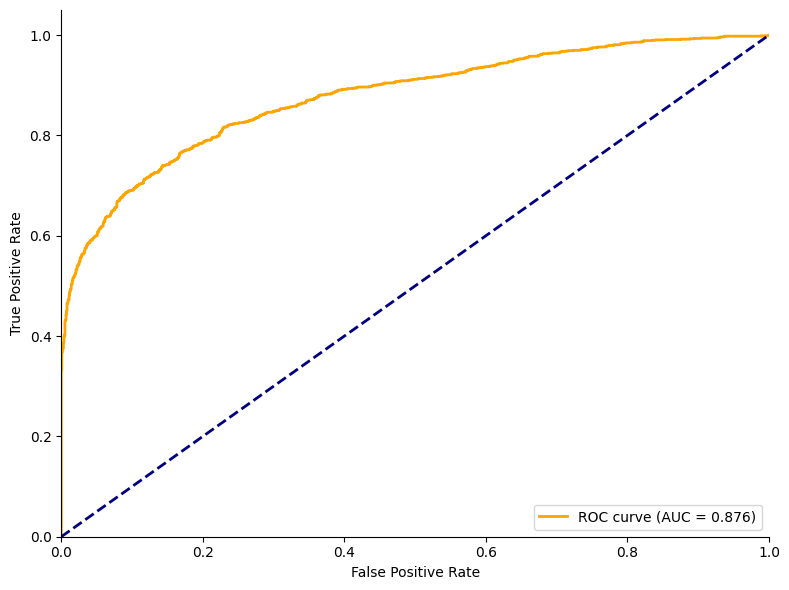

In [50]:
# Predict probabilities on the test set
y_prob = model.predict([X_te_f, X_te_lab]).ravel()  # Flatten to 1D

# Predict class labels if needed
y_pred = (y_prob > 0.5).astype(int)


# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.3f})', color='orange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# plt.grid()
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_roc_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_roc_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()


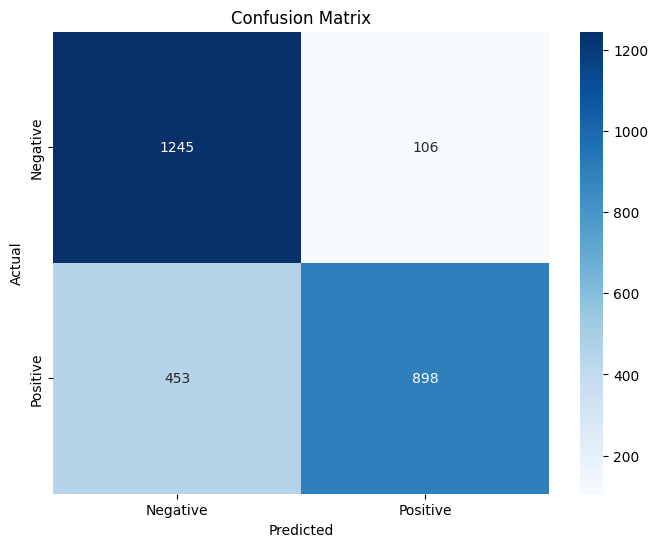

In [52]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# print mathews correlation coefficient
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient: {mcc:.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
plt.show()

Matthews Correlation Coefficient: 0.607
Accuracy: 0.793


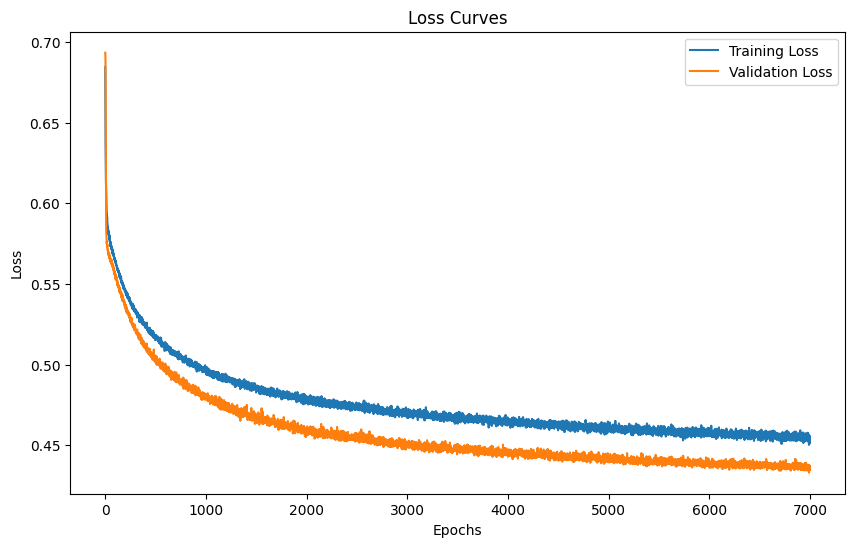

In [37]:
# plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_loss_curves.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_loss_curves.pdf', dpi=300, bbox_inches='tight')
plt.show()

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


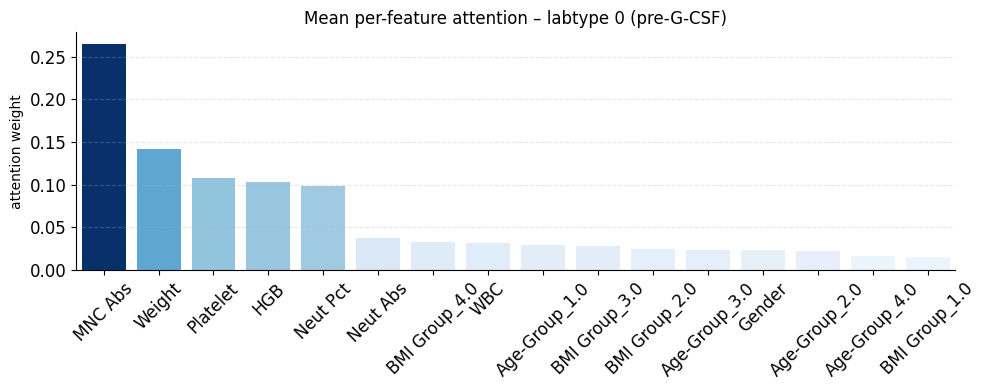

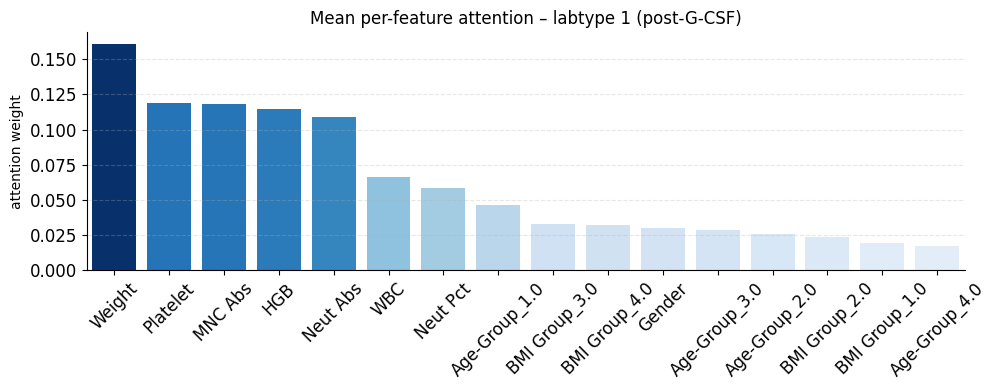

In [38]:
att_test = att_extractor.predict([X_te_f, X_te_lab])
att_df   = pd.DataFrame(att_test, columns=X_train.drop(columns=['labtype']).columns)
att_df['labtype'] = X_test['labtype'].values


for lt in (0,1):
    mean_w = att_df[att_df.labtype==lt].drop(columns=['labtype']).mean()
    ax = plt.figure(figsize=(10,4))
    # sort the mean weights for better visualization
    mean_w = mean_w.sort_values(ascending=False)
    mean_w.plot(kind='bar')
    plt.title(f'Mean per-feature attention – labtype {lt} '
              f"({'post' if lt==1 else 'pre'}-G-CSF)")
    plt.ylabel('attention weight')
    # make the axes size thicker for better visibility
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # use gradiend color for bars
    plt.bar(mean_w.index, mean_w.values, color=plt.cm.Blues(mean_w.values / mean_w.max()))
    
    sns.despine()
    plt.tight_layout()
    plt.savefig(here() / config.plots / 'cibmtr' / f'cibmtr_attn_weights_labtype_{lt}.png', dpi=300, bbox_inches='tight')
    plt.savefig(here() / config.plots / 'cibmtr' / f'cibmtr_attn_weights_labtype_{lt}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

Average Precision: 0.899
F1 Score: 0.763
Precision: 0.894
Recall: 0.665


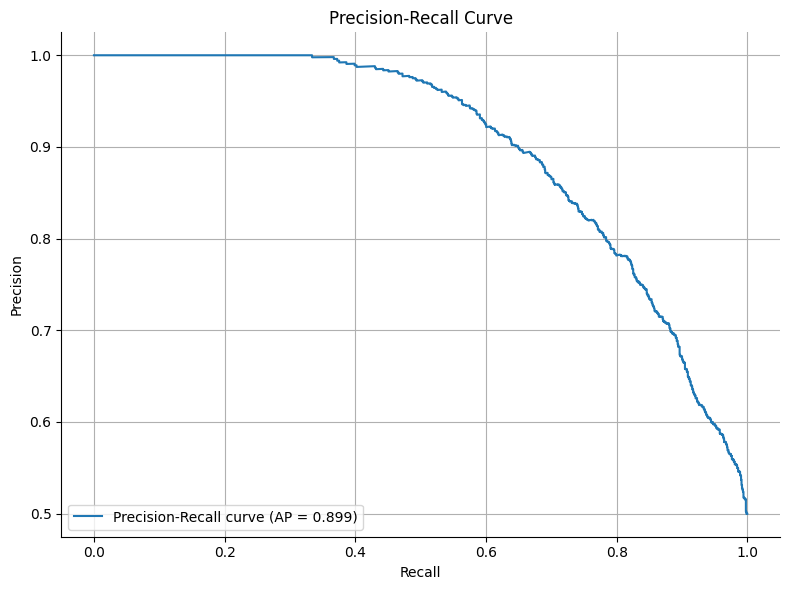

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score
# Calculate precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
# Calculate average precision score
average_precision = average_precision_score(y_test, y_prob)
# Calculate F1 score
f1 = f1_score(y_test, y_pred)
# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Average Precision: {average_precision:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:0.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'cibmtr' / 'cibmtr_precision_recall_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# save the model 
model.save(here() / config.model_dl / 'cibmtr_attn_model_hsu.keras')
# save the history
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv(here() / config.model_dl / 'cibmtr_attn_history_hsu.csv', index=False)

# save the attention weights
att_df.to_csv(here() / config.model_dl / 'cibmtr_attn_weights_hsu.csv', index=False)
# save the model


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


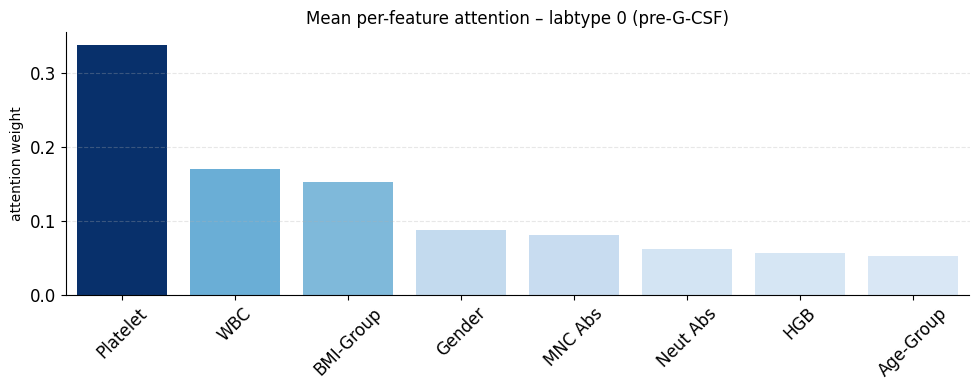

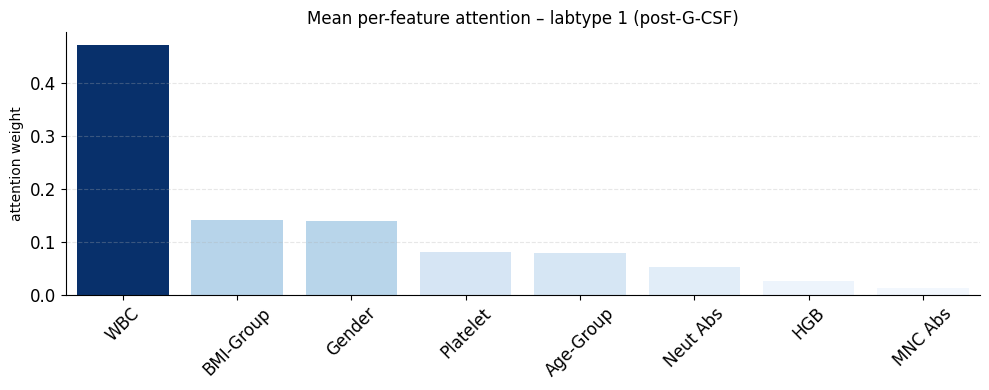

In [66]:
att_test = att_extractor.predict([X_te_f, X_te_lab])
att_df   = pd.DataFrame(att_test, columns=X_train.drop(columns=['labtype']).columns)
att_df['labtype'] = X_test['labtype'].values


for lt in (0,1):
    mean_w = att_df[att_df.labtype==lt].drop(columns=['labtype']).mean()
    ax = plt.figure(figsize=(10,4))
    # sort the mean weights for better visualization
    mean_w = mean_w.sort_values(ascending=False)
    mean_w.plot(kind='bar')
    plt.title(f'Mean per-feature attention – labtype {lt} '
              f"({'post' if lt==1 else 'pre'}-G-CSF)")
    plt.ylabel('attention weight')
    # make the axes size thicker for better visibility
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # use gradiend color for bars
    plt.bar(mean_w.index, mean_w.values, color=plt.cm.Blues(mean_w.values / mean_w.max()))
    
    sns.despine()
    plt.tight_layout()
    plt.show()